In [1]:
import json
import os

In [2]:
!nvidia-smi

Wed Dec 16 20:17:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     On   | 00000000:1B:00.0 Off |                  Off |
| 33%   33C    P8    10W / 230W |      0MiB / 16095MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 5000     On   | 00000000:3E:00.0 Off |                  Off |
| 33%   26C    P8    15W / 230W |    320MiB / 16095MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Q

In [3]:
path = '/docvqa/train/train_v1.0.json'
j = json.load(open(path))
j['data'][1]

{'questionId': 338,
 'question': 'what is the contact person name mentioned in letter?',
 'image': 'documents/xnbl0037_1.png',
 'docId': 279,
 'ucsf_document_id': 'xnbl0037',
 'ucsf_document_page_no': '1',
 'answers': ['P. Carter', 'p. carter'],
 'data_split': 'train'}

In [4]:
import os
import json
import torch
from PIL import Image
import numpy as np
import random
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import matplotlib.pyplot as plt
import metrics

In [5]:
tokenizer_string = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(tokenizer_string)

In [6]:
'''
Abstracts DocVQA
'''


class DocVQA(Dataset):

    def __init__(self,
                 mode: str,
                 transform: object = None,
                 seq_len: int = 128):
        '''
        mode: one of train, val and test.
        transform: transforms to be applied to the document image if applicable.
        seq_len: maximum sequence len of encoded tokens.

        returns:
            dict:
                document: transformed document image.
                input_tokens: tokenized text contained in the document.
                input_text: text contained in the document.
                bboxes: bounding boxes for each OCR detection in the document, on the format [tl_col, tl_row, br_col, br_row].
        '''
        super().__init__()
        assert mode in ["train", "val", "test"]
        with open(f"/docvqa/{mode}/{mode}_v1.0.json", 'r') as data_json_file:
            self.data_json = json.load(data_json_file)

        self.folder = f"/docvqa/{mode}"
        self.transform = transform
        self.seq_len = seq_len
        self.mode = mode

        print(f"{self.mode} DocVQA folder {self.folder} tokenizer {tokenizer.__class__.__name__} transform {self.transform} seq_len {self.seq_len}")

    def __len__(self):
        return len(self.data_json["data"])

    def __getitem__(self, i: int):
        data = self.data_json["data"][i]
        
        document = Image.open(os.path.join(self.folder, data["image"])).convert("RGB")
        
        question_text = data['question']
        answer_text = np.random.choice(data.get('answers', ["N/A"]))
        
        target_text = "question: " + question_text.strip() + " answer: " + answer_text.strip()
        

#         target_ids = self.tokenizer.encode(target_text,
#                                        padding='max_length',
#                                        truncation=True,
#                                        max_length=self.seq_len,
#                                        return_tensors='pt')[0]

        if self.transform is not None:
            document = self.transform(document)

        return {"document": document,
                "question": question_text,
                "answer": answer_text,
                "target_text": target_text}

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from transformers import AdamW
from torchvision import transforms
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks.base import Callback

max_length = 128


class CaptioningModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        # EfficientNet image encoder.
        self.encoder = EfficientNet.from_pretrained('efficientnet-b0')

        self.decoder = T5ForConditionalGeneration.from_pretrained(tokenizer_string)
        # for par in self.decoder.base_model.parameters():
        #     par.requires_grad = False
        
        # Bridge convolution layer between efficientnet and transformer formats.
        self.bridge = nn.Conv2d(in_channels=112, out_channels=self.decoder.config.d_model, kernel_size=1)
        
    def _embeds_forward(self, img):

        # Retrieve the features from the last layer.
        # https://github.com/lukemelas/EfficientNet-PyTorch/blob/master/efficientnet_pytorch/model.py#L231
        #
        # >>> img = torch.ones((1, 3, 256, 256))
        # >>> encoder.extract_features(img).shape
        # torch.Size([1, 1280, 8, 8])
        # features = self.encoder.extract_features(img)
        features = self.encoder.extract_endpoints(img)["reduction_4"] 

        # print(features.shape)

        # Compute the bridge convolution, it should reformat the inputs to feed the transformer network.
        features = self.bridge(features)
        
        # Reshape the output to match the embedding dimension of the encoder with 64 tokens.
        inputs_embeds = features \
            .permute(0, 2, 3, 1) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        return inputs_embeds

    def forward(self, img=None, inputs_embeds=None, decoder_input_ids=None, labels=None):

        # Pass efficientnet hidden states as embeddings for the transformer encoder input.
        inputs_embeds = self._embeds_forward(img) if inputs_embeds is None else inputs_embeds

        return self.decoder(
            inputs_embeds=inputs_embeds,
            decoder_input_ids=decoder_input_ids, 
            labels=labels,
        )

    def generate(self, img, max_len=max_length):

        # We need to implement our own generate loop as transformers doesn't accept 
        # precomputed embeddings on the generate method.
        # Issue: https://github.com/huggingface/transformers/issues/7626
        # Precompute embeddings to speedup generation as they don't change.
        inputs_embeds = self._embeds_forward(img)
        
        decoder_input_ids = torch.full(
            (1, 1), self.decoder.config.decoder_start_token_id, dtype=torch.long, device=img.device
        )
        
        for i in range(max_len):
            with torch.no_grad():
                output = self.forward(decoder_input_ids=decoder_input_ids, 
                                      inputs_embeds=inputs_embeds)

                logits = output[0]
                next_token_logits = logits[:, -1, :]
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1).to(img.device)

                if torch.eq(next_token_id[:, -1], self.decoder.config.eos_token_id).all():
                    break

        return decoder_input_ids

    def training_step(self, batch, batch_idx):
        img, targets, raw_text = batch
        output = self(img, labels=targets)
        return output[0]

    def validation_step(self, batch, batch_idx):
        img, targets, raw_text = batch
        
        tokens = [self.generate(im.view((1,) + im.shape))[0].cpu() for im in img]

        with torch.no_grad():        
            loss_val = self(img, labels=targets)[0].item()

        return (tokens, raw_text, img, loss_val)

    def validation_epoch_end(self, validation_step_outputs):
        
        validation_step_outputs = list(validation_step_outputs)
    
        tokens_batch = [t for out in validation_step_outputs for t in out[0]]
        reference_batch = [r for out in validation_step_outputs for r in out[1]]
        # img_batch = [i for out in validation_step_outputs for i in out[2]]
        hist_loss_val = np.mean([out[3] for out in validation_step_outputs])
        
        generated_batch = tokenizer.batch_decode(tokens_batch)
        

        F1_val = np.mean([metrics.compute_f1(gold, pred) for gold, pred in zip(reference_batch,
                                                                    generated_batch)])


        exact_val = np.mean([metrics.compute_exact(gold, pred) for gold, pred in zip(reference_batch,
                                                                            generated_batch)])
        
        self.log("loss_val", hist_loss_val, prog_bar=True)
        self.log("exact_val", exact_val, prog_bar=True)
        self.log("F1_val", F1_val, prog_bar=True)

    def test_step(self, batch, batch_idx):
        img, targets, raw_text = batch
        
        tokens = [self.generate(im.view((1,) + im.shape))[0].cpu() for im in img]
        
        return (tokens, raw_text, img.cpu())
    
    def test_epoch_end(self, test_step_outputs):
        test_step_outputs = list(test_step_outputs)
    
        tokens_batch = [t for out in test_step_outputs for t in out[0]]
        reference_batch = [r for out in test_step_outputs for r in out[1]]
        
        generated_batch = tokenizer.batch_decode(tokens_batch)
        
        F1_test = np.mean([metrics.compute_f1(gold, pred) for gold, pred in zip(reference_batch,
                                                                    generated_batch)])


        exact_test = np.mean([metrics.compute_exact(gold, pred) for gold, pred in zip(reference_batch,
                                                                            generated_batch)])
        
        self.log("exact_test", exact_test, prog_bar=True)
        self.log("F1_test", F1_test, prog_bar=True)

        return {"exact_test": exact_test,
                "F1_test": F1_test}
    
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=5e-4)

# Experimentando, testando e salvando

In [8]:
def collate_fn(batch):
    """
    Input any (selected randomly) caption sample for every image. Useful for training.
    """
    #lista de [imagem, token_ids, texto_original]
    imgs = [r['document'].numpy() for r in batch]
    texts = [r['target_text'] for r in batch]


    tokens_ids = tokenizer.batch_encode_plus(texts,
                                               truncation=True, 
                                               return_tensors="pt", 
                                               padding="max_length",
                                               max_length=max_length)['input_ids']
    
    return (
        torch.Tensor(imgs),
        tokens_ids, 
        texts,
    )


val_test_transforms = transforms.Compose([transforms.Resize((700, 400)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std =[0.229, 0.224, 0.225])
                        ])


#cria os datasets necessáios
dataset_train = DocVQA(mode='train', transform=val_test_transforms)

batch = 3
num_workers = 8

debug_train = DataLoader(dataset_train, 
                                batch_size=batch,
                                shuffle=True,
                                pin_memory=True,
                                num_workers=num_workers,
                                collate_fn=collate_fn)


train DocVQA folder /docvqa/train tokenizer T5Tokenizer transform Compose(
    Resize(size=(700, 400), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
) seq_len 128


In [9]:
train_transforms = transforms.Compose([transforms.Resize((700, 400)),
                                    transforms.ColorJitter(0.2, 0.3, 0.3, 0.4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std =[0.229, 0.224, 0.225])
                        ])


val_test_transforms = transforms.Compose([transforms.Resize((700, 400)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std =[0.229, 0.224, 0.225])
                        ])


#cria os datasets necessáios
dataset_train = DocVQA(mode='train', transform=train_transforms)
dataset_val = DocVQA(mode='val', transform=val_test_transforms)
dataset_test = DocVQA(mode='test', transform=val_test_transforms)

batch = 4

num_workers = 8
dataloader_train = DataLoader(dataset_train, 
                                batch_size=batch,
                                shuffle=True,
                                pin_memory=True,
                                num_workers=num_workers,
                                collate_fn=collate_fn)

dataloader_val = DataLoader(dataset_val, 
                            batch_size=batch,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=num_workers,
                            collate_fn=collate_fn)


dataloader_test = DataLoader(dataset_test, 
                            batch_size=batch,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=num_workers,
                            collate_fn=collate_fn)


# path_to_checkpoint= '/captioning-epoch=14-loss_val=0.68-docvqa80.ckpt'
path_to_checkpoint = '/logs/captioning-epoch=2-F1_val=0.35-docvqa80.ckpt'

if not os.path.isfile(path_to_checkpoint):
    path_to_checkpoint = None
else:
    print(f"Logging from: {path_to_checkpoint}")

print(path_to_checkpoint)
model = CaptioningModule().to('cuda')

train DocVQA folder /docvqa/train tokenizer T5Tokenizer transform Compose(
    Resize(size=(700, 400), interpolation=PIL.Image.BILINEAR)
    ColorJitter(brightness=[0.8, 1.2], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.4, 0.4])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
) seq_len 128
val DocVQA folder /docvqa/val tokenizer T5Tokenizer transform Compose(
    Resize(size=(700, 400), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
) seq_len 128
test DocVQA folder /docvqa/test tokenizer T5Tokenizer transform Compose(
    Resize(size=(700, 400), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
) seq_len 128
Logging from: /logs/captioning-epoch=2-F1_val=0.35-docvqa80.ckpt
/logs/captioning-epoch=2-F1_val=0.35-docvqa80.ckpt
Loaded pretrained weights for efficientnet-b0


Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded pretrained weights for efficientnet-b0


Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


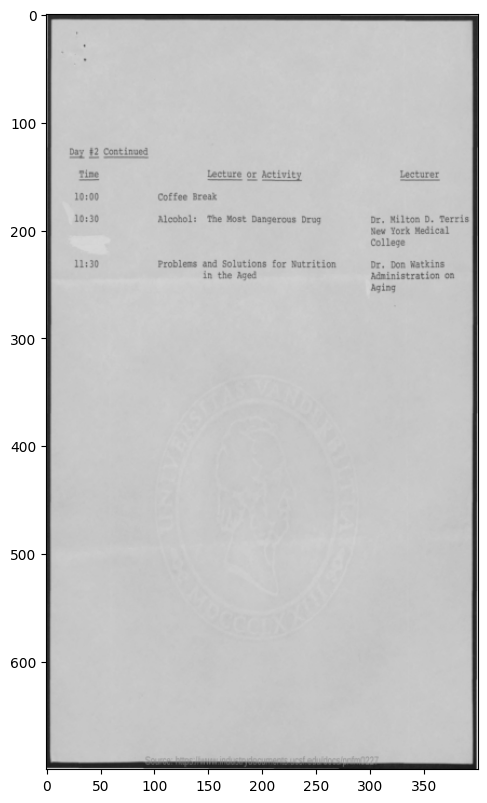

Predito =  <pad> <extra_id_0> <extra_id_1> sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox sandbox s</s>
Real =  question: what is the name of the activity at the time of 11:30 as mentioned ? answer: Problems and Solutions for Nutrition in the Aged



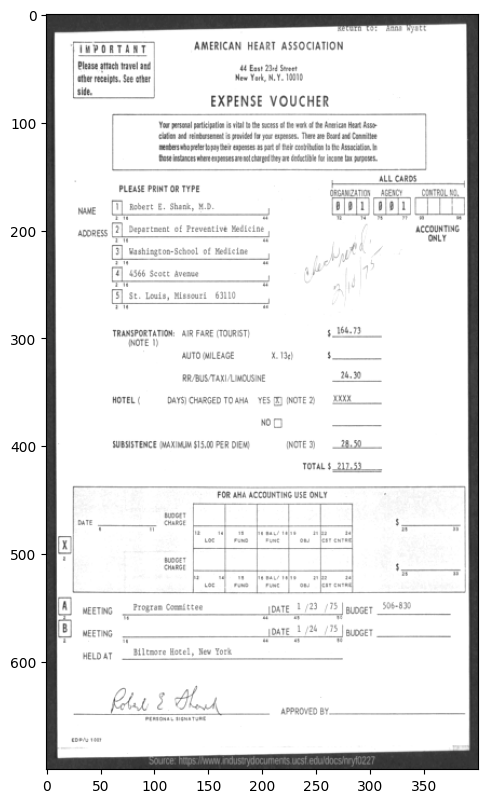

Predito =  <pad> <extra_id_0> ad<extra_id_1> ad<extra_id_2> ad<extra_id_3> ad<extra_id_4> ad<extra_id_5> ad<extra_id_6> ad<extra_id_7> ad<extra_id_8> ad<extra_id_9> ad<extra_id_10> ad<extra_id_11> ad<extra_id_12> ad<extra_id_13> <extra_id_14> ad<extra_id_15> ad<extra_id_16> ad<extra_id_17> ad<extra_id_18> <extra_id_19> ad<extra_id_20> ad<extra_id_21> ad<extra_id_22> ad<extra_id_23> ad<extra_id_24> ad hoc<extra_id_25> ad hoc<extra_id_26> ad hoc<extra_id_27> a</s>
Real =  question: Which association is mentioned? answer: AMERICAN HEART ASSOCIATION



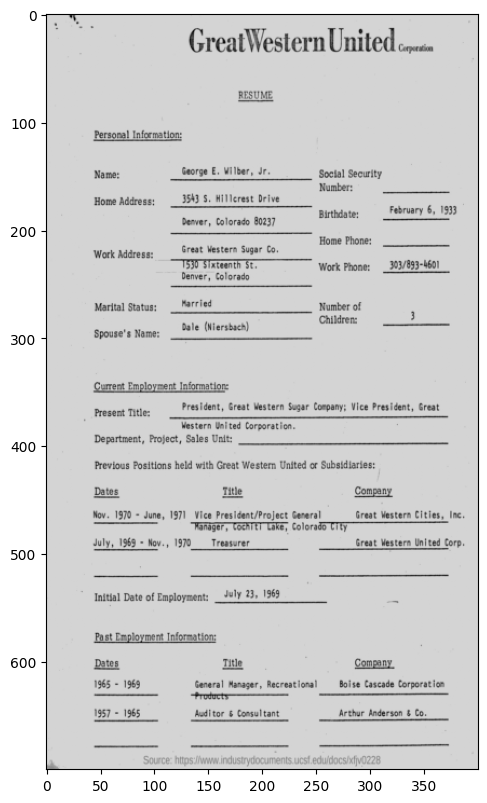

Predito =  <pad> <extra_id_0> a<extra_id_1> a learning experience<extra_id_2> a learning experience<extra_id_3> learning experience<extra_id_4> learning experience<extra_id_5> learning experience<extra_id_6> learning experience<extra_id_7> a learning experience<extra_id_8> a learning experience<extra_id_9> a learning experience<extra_id_10> a learning experience<extra_id_11> a learning experience<extra_id_12> a learning experience<extra_id_13> a learning experience<extra_id_14> a learning experience<extra_id_15> a learning experience<extra_id_16> <extra_id_17> a learning experience<extra_id_18> a learning experience<extra_id_19> a learning experience<extra_id_20> a learning experience<extra_id_21> a learning experience<extra_id_22> a learning experience<extra_id_23> a learning<extra_id_24> <extra_id_25> <extra_id_26> <extra_id_27> </s>
Real =  question: What is the Spouse's Name of George E. Wilber, Jr. ? answer: Dale  (Niersbach)



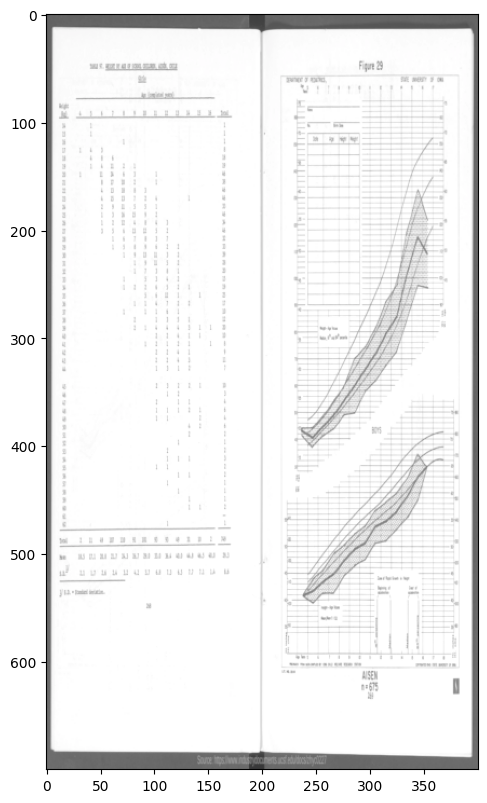

Predito =  <pad> <extra_id_0> <extra_id_1> a specialized, specialized, and specialized training and development toolkit for a variety of<extra_id_2> <extra_id_3> <extra_id_4> a<extra_id_5> <extra_id_6> a<extra_id_7> a<extra_id_8> <extra_id_9> <extra_id_10> <extra_id_11> <extra_id_12> <extra_id_13> <extra_id_14> <extra_id_15> <extra_id_16> <extra_id_17> <extra_id_18> <extra_id_19> a symbiotic relationship with a symbiotic relationship with a symbiotic relationship with a symbiotic relationship with a symbiotic relationship<extra_id_20>.<extra_id_21>.<extra_id_24> <extra_id_25> </s>
Real =  question: What is the total number of children having weight 45? answer: 10



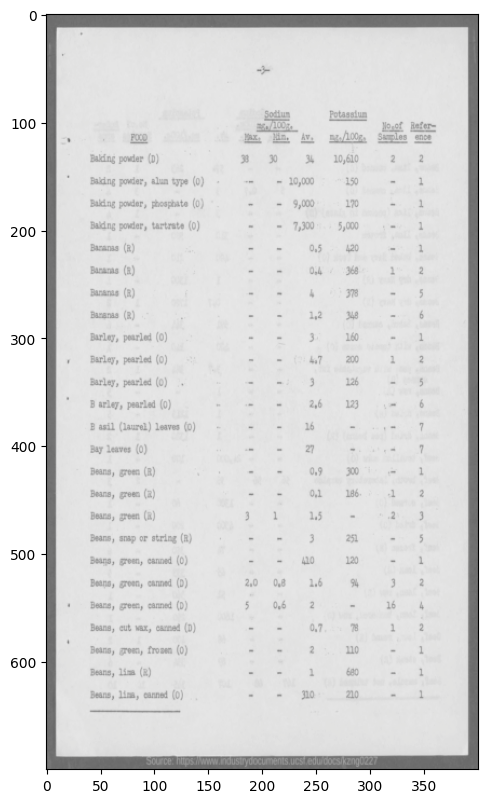

Predito =  <pad> <extra_id_0> <extra_id_1> a symphony of a symphony of a symphony of a symphony of a symphony of a symphony of a symphony of a symphony of a symphony of a symphony of a symphony of a symphony of a</s>
Real =  question: what is the amount of potassium mg./100g.  of Baking Powder, Tartrate(O)? answer: 5000



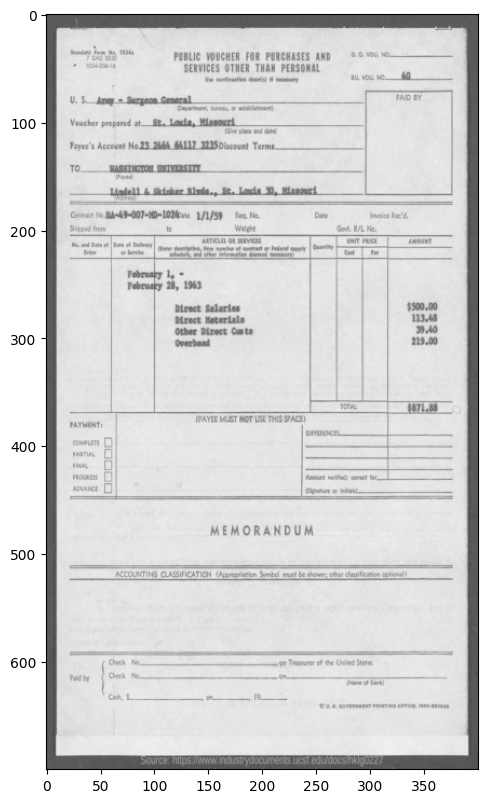

Predito =  <pad> <extra_id_0> <extra_id_1> <extra_id_2> <extra_id_3> adobe emojis<extra_id_4> adobe emojis<extra_id_5> adobe emojis<extra_id_6> adobe emojis<extra_id_7> adobe emojis<extra_id_8> adobe emojis<extra_id_9> adobe emojis emojis emojis emojis emojis emojis</s>
Real =  question: What type of voucher is given here? answer: PUBLIC VOUCHER FOR PURCHASES AND SERVICES OTHER THAN PERSONAL



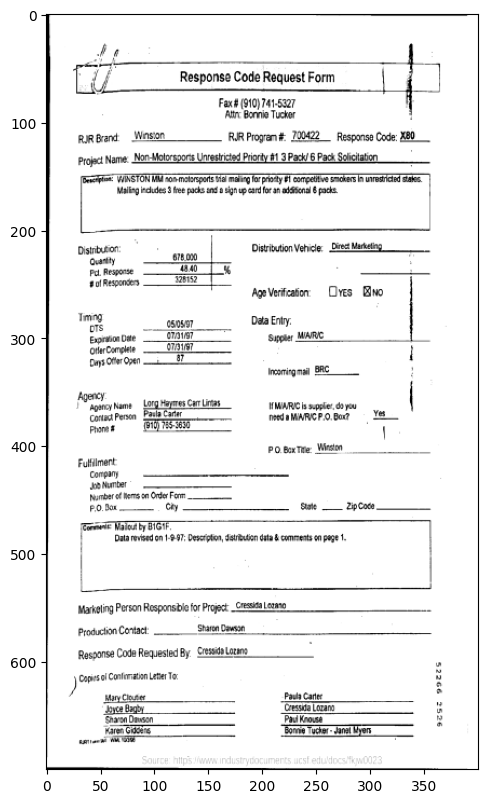

Predito =  <pad> <extra_id_0> ad hoc e-learning platform for enhancing your learning experience<extra_id_1> e-learning platform for enhancing your learning experience<extra_id_2> e-learning platform for enhancing your learning experience<extra_id_3> e-learning platform for enhancing your learning experience<extra_id_4> e-learning platform for enhancing your learning experience<extra_id_5> e-learning platform for enhancing your learning experience<extra_id_6> e-learning platform for enhancing your learning experience<extra_id_7>.<extra_id_8>.<extra_id_17>. e-learning platform<extra_id_18>.<extra_id_19>.<extra_id_20>.<extra_id_21>.<extra_id_22>.<extra_id_27> e</s>
Real =  question: What is the RJR Program # ? answer: 700422



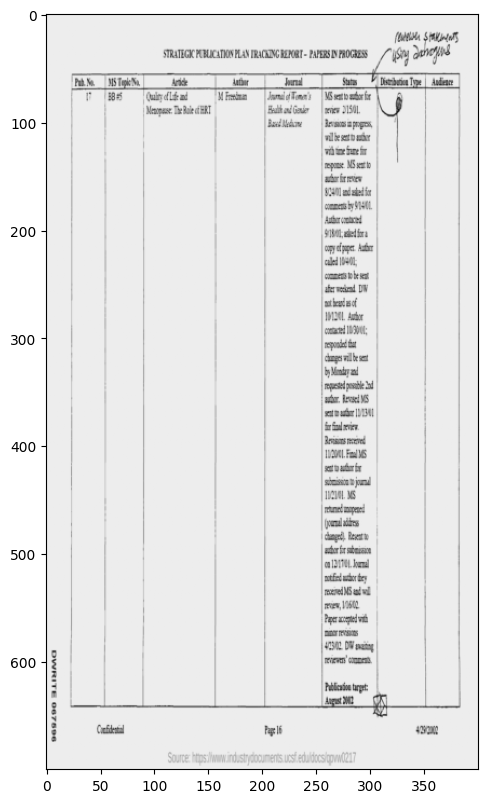

Predito =  <pad> <extra_id_0> <extra_id_1> s<extra_id_2> <extra_id_3> <extra_id_4> <extra_id_5> <extra_id_6> s<extra_id_7> <extra_id_8>.<extra_id_9> s<extra_id_10> <extra_id_11> <extra_id_12> <extra_id_13> sylvane sylvane sylvane sylvane sylvane sylvane sylvane sylvane sylvane sylvane sylvane<extra_id_14> <extra_id_15> <extra_id_16>.<extra_id_17> <extra_id_18>.<extra_id_19>.<extra_id_20>.<extra_id_21>.<extra_id_27> </s>
Real =  question: What is the name of the article? answer: QUALITY OF LIFE AND MENOPAUSE: THE ROLE OF HRT



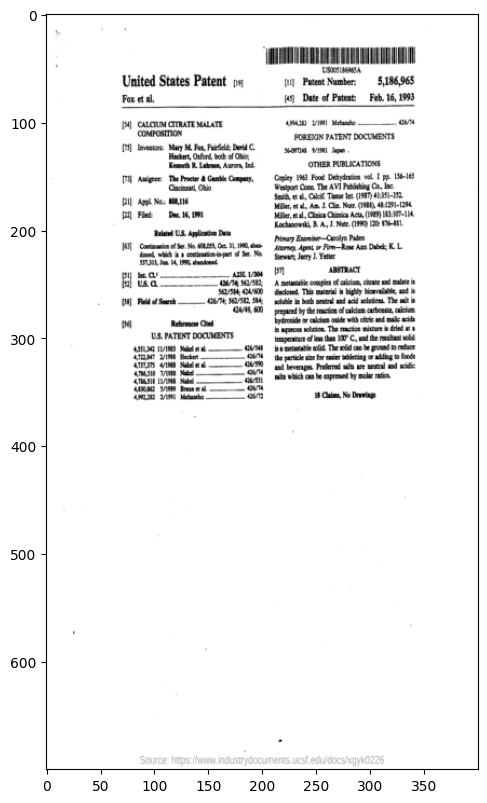

Predito =  <pad> <extra_id_0> <extra_id_1> ad hoc e-learning platform for enhancing learning and learning<extra_id_2> ad hoc e-learning platform for enhancing learning and learning<extra_id_3> <extra_id_4> <extra_id_5> <extra_id_6> a<extra_id_7> <extra_id_8> <extra_id_9> <extra_id_10> <extra_id_11> <extra_id_12> <extra_id_13> <extra_id_14> <extra_id_15> <extra_id_16> <extra_id_17> <extra_id_18> <extra_id_19> <extra_id_20> <extra_id_21> <extra_id_22> <extra_id_23> ad hoc e-learning platform for enhancing learning and learning <extra_id_24> a<extra_id_25> ad hoc e-learning platform<extra_id_26> <extra_id_27> </s>
Real =  question: What is  the solubility of this salt? answer: SOLUBLE IN BOTH NEUTRAL AND ACID SOLUTIONS



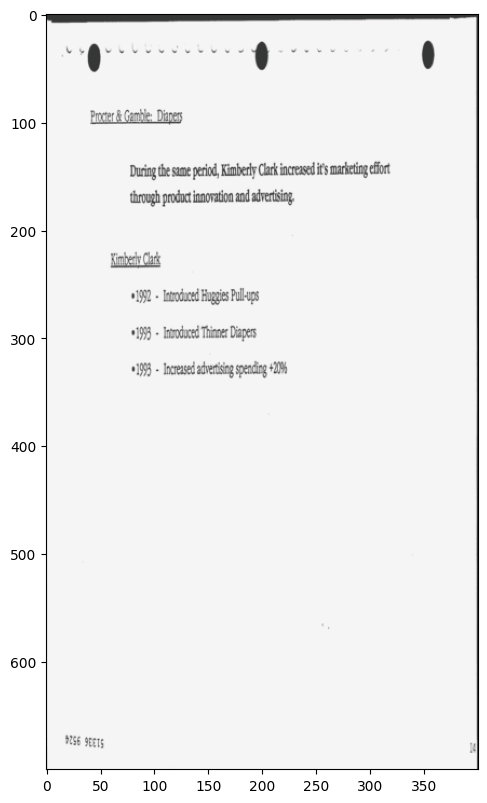

Predito =  <pad> </s>
Real =  question: When was advertising spending Increased +20%? answer: 1993



In [12]:
mean=[0.485, 0.456, 0.406]
std =[0.229, 0.224, 0.225]

model.load_from_checkpoint(path_to_checkpoint)
model.eval()

def show_k_from_batch(dataset):

    test_loader = DataLoader(dataset, 
                             batch_size=1, 
                             collate_fn=collate_fn, 
                             shuffle=True)

    with torch.no_grad():
        for batch, i in zip(test_loader, range(10)):
                
            imgs, _, refs = batch

            for (img, ref) in zip(imgs, refs):

                tokens = model.generate(img.view((1,) + img.shape).cuda())
                
                for t, m, s in zip(img, mean, std):
                    t.mul_(s).add_(m)
                
                norm_img = img.numpy()

                plt.figure(figsize = (10,10), dpi=100)
                plt.imshow(np.moveaxis(norm_img, 0, 2))
                plt.show()
                
                print("Predito = ", tokenizer.batch_decode(tokens)[0])
                print("Real = ", ref)
                print()
                
                


show_k_from_batch(dataset_train)